# 개와 고양이 분류를, 이미 잘 만들어진 뉴널네트워크를 활용하여, 성능을 올려보자.

![alt text](https://live.staticflickr.com/4544/38228876666_3782386ca7_b.jpg)



### Downloading the Dogs vs Cats dataset

In [1]:
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip \
    -O ./cats_and_dogs_filtered.zip

--2025-10-02 05:22:33--  https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 142.250.107.207, 142.251.188.207, 192.178.163.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|142.250.107.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 68606236 (65M) [application/zip]
Saving to: ‘./cats_and_dogs_filtered.zip’

./cats_and_dogs_fil 100%[===================>]  65.43M   280MB/s    in 0.2s    

2025-10-02 05:22:33 (280 MB/s) - ‘./cats_and_dogs_filtered.zip’ saved [68606236/68606236]



## Stage 2: Dataset preprocessing

### Import project dependencies

In [3]:
import os
import zipfile
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras


### Unzipping the Dogs vs Cats dataset

In [4]:
zipfile.ZipFile("./cats_and_dogs_filtered.zip", 'r').extractall("./")

### Seting up dataset paths

In [5]:
base_dir = './cats_and_dogs_filtered'
train_dir = './cats_and_dogs_filtered/train'
validation_dir = './cats_and_dogs_filtered/validation'

In [75]:
IMG_SIZE = 128  #### 이미지 사이즈를 128로 한 이유는! MobileNetV2 가 128로 넣어야 하기 때문!
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

## Building the model : MobileNetV2 를 활용


### pre trained model : https://www.tensorflow.org/api_docs/python/tf/keras/applications

## Loading the pre-trained model (MobileNetV2)

모바일이나, 임베디드에서도 실시간을 작동할 수 있게 모델이 경량화 되면서도, 정확도 또한 많이 떨어지지 않게하여, 속도와 정확도 사이의 트레이드 오프 문제를 어느정도 해결한 네트워크 입니다.

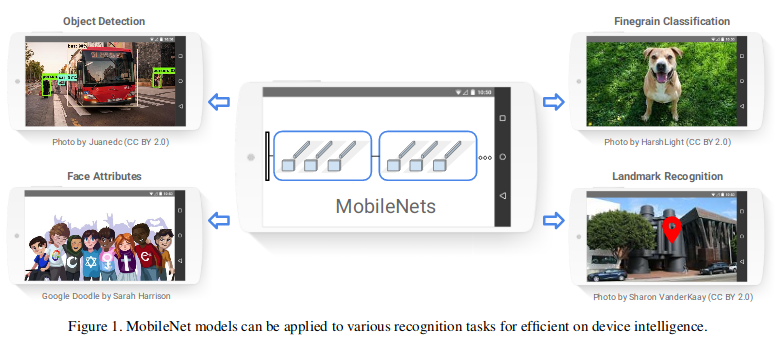

In [76]:
train_ds = keras.utils.image_dataset_from_directory(train_dir,
                                         image_size=(IMG_SIZE, IMG_SIZE),
                                         batch_size=128,
                                         shuffle= True,  # 훈련용 데이터는 잘 섞어서 학습시킨다.
                                         seed = 77)

Found 2000 files belonging to 2 classes.


In [77]:
validation_ds = keras.utils.image_dataset_from_directory(validation_dir,
                                         image_size=(IMG_SIZE, IMG_SIZE),
                                         batch_size=128,
                                         shuffle= False )  # 테스트 데이터는 섞지말자. 그대로 사용한다 (평가 일관성 때문)

Found 1000 files belonging to 2 classes.


In [78]:
train_ds.class_names

['cats', 'dogs']

In [79]:
validation_ds.class_names

['cats', 'dogs']

In [80]:
# 성능 최적화
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(AUTOTUNE)
validation_ds = validation_ds.prefetch(AUTOTUNE)

In [81]:
# 데이터 증강
#### 주의할점 ####
#### MobileNetV2 를 사용할때는, 피처스케일링할때, -1 ~ 1 사이의 값으로 피처스케일링해야한다.
#### 왜? MobileNetV2 만든 사람들이 피처스케일링을 그렇게 했으니까.

In [82]:
data_augmentation = keras.Sequential()
data_augmentation.add( keras.layers.RandomFlip('horizontal')  )  # 좌우를 대칭으로 변경.
data_augmentation.add( keras.layers.RandomRotation(0.05) )     # -5% ~ + 5% 회전
data_augmentation.add( keras.layers.RandomZoom(0.1) )    # -10% ~ 10% 줌
data_augmentation.add( keras.layers.RandomTranslation( 0.05, 0.05  ) )  # -5% ~ 5% 로, 위아래도 이동시키고, 왼쪽오른쪽도 이동.
data_augmentation.name = 'data_augmentation'

In [83]:
base_model = keras.applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=False,weights='imagenet' )

In [84]:
# MobileNetV2 아키텍처 확인해보자.
base_model.summary()

Model: "mobilenetv2_1.00_128"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_20      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 64, 64,    │        864 │ input_layer_20[0… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 64, 64,    │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 64, 64,    │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 64, 64,    │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 64, 64,    │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 64, 64,    │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 64, 64,    │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 64, 64,    │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 65, 65,    │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 32, 32,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 32, 32,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 32, 32,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 2,223,872 (8.48 MB)

 Non-trainable params: 34,112 (133.25 KB)

In [85]:
# 레이어 갯수 확인
len( base_model.layers )

154

In [86]:
# MobileNetV2 를 가져온, base_model은 학습이 되면 안된다.
# 이 부분은 학습하려고 가져온게 아니라, 특징을 잡아내라고 가져온것이기 때문이다.
base_model.trainable = False

In [87]:
# Functional API (함수형 API) 를 이용해서 모델링한다.

In [88]:
inputs = keras.Input(shape= IMG_SHAPE )
#### 데이터 프리프로세싱 부분
x = data_augmentation(inputs)   # 데이터 증강
x = keras.layers.Rescaling( scale= 1/127.0 , offset= -1.0  )(x) # 피처스케일링하되, MobileNetV2는 -1~1로!

#### 특징을 잡는 부분 : 똑똑한 애들이 이미 만들어놓은 pre-trained model을 이용한다.
x = base_model(x, training = False)

#### 이 아래부분은 우리가 작성 : 분류하는 부분이다.
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(units= 128, activation= keras.activations.relu)(x)
x = keras.layers.Dropout(0.2)(x)
# 개냐 고양이냐, 0과1로 분류하는 인공지능이므로, 뉴런은 1개, 액티베이션은 시그모이드를 써야한다.
outputs = keras.layers.Dense(units= 1, activation= keras.activations.sigmoid)(x)


In [89]:
# 두개 부분을 하나로 합치면, 인공지능이 된다.
model = keras.Model(inputs= inputs, outputs= outputs)

In [90]:
# 컴파일 한다.
# 트랜스퍼러닝(pre-trained model + 우리모델)을 할때는 옵티마이저의 러닝레이트를 0.0001 ~ 0.001 사이로 셋팅
# 해야, 학습이 잘된다.

model.compile(optimizer= keras.optimizers.Adam( learning_rate=0.0001 ) ,
              loss= keras.losses.BinaryCrossentropy(),
              metrics = [keras.metrics.BinaryAccuracy()])

In [91]:
model.fit(train_ds, epochs= 5)

Epoch 1/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 6s 93ms/step - binary_accuracy: 0.7109 - loss: 0.5713
Epoch 2/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 117ms/step - binary_accuracy: 0.9063 - loss: 0.2736
Epoch 3/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 138ms/step - binary_accuracy: 0.9348 - loss: 0.1954
Epoch 4/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 2s 97ms/step - binary_accuracy: 0.9303 - loss: 0.1697 
Epoch 5/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 3s 98ms/step - binary_accuracy: 0.9437 - loss: 0.1515 


In [92]:
model.evaluate(validation_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 2s 92ms/step - binary_accuracy: 0.9720 - loss: 0.0867


[0.09125163406133652, 0.9700000286102295]

In [96]:
# === 1) Google Colab에서 이미지 업로드 → 예측 ===
from google.colab import files
uploaded = files.upload()  # 파일 선택 → 업로드

import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.utils import load_img, img_to_array
from keras.applications.mobilenet_v2 import preprocess_input

# 업로드한 모든 파일에 대해 예측
for fname in uploaded.keys():
    # 1) 이미지 로드 & 리사이즈 & RGB
    img = load_img(fname, target_size=(IMG_SIZE, IMG_SIZE), color_mode="rgb")
    x = img_to_array(img)            # (H,W,C)
    x = np.expand_dims(x, axis=0)    # (1,H,W,C)
    x = preprocess_input(x)          # MobileNetV2: [-1,1] 스케일

    print(x.min(), x.max())

    # 2) 예측 (이진 분류: 1 유닛 시그모이드 → '개' 확률로 가정)
    prob_dog = float(model.predict(x, verbose=0)[0][0])
    pred = "dog" if prob_dog >= 0.5 else "cat"
    print(f"{fname} -> prob_dog={prob_dog:.4f}  pred={pred}")


Saving 강아지-입벌림-scaled.jpg to 강아지-입벌림-scaled (1).jpg
-0.99215686 0.9843137
강아지-입벌림-scaled (1).jpg -> prob_dog=0.2807  pred=cat


In [59]:
### EfficientNetV2B0 이용
base_model = keras.applications.EfficientNetV2B0(input_shape=IMG_SHAPE, include_top=False,weights='imagenet' )

24274472/24274472 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
base_model.trainable = False

In [60]:
IMG_SIZE = 224  #### 이미지 사이즈를 224로 한 이유는!EfficientNetV2B0 224로 넣어야 하기 때문!
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

In [61]:
train_ds = keras.utils.image_dataset_from_directory(train_dir,
                                         image_size=(IMG_SIZE, IMG_SIZE),
                                         batch_size=128,
                                         shuffle= True,  # 훈련용 데이터는 잘 섞어서 학습시킨다.
                                         seed = 77)

Found 2000 files belonging to 2 classes.


In [62]:
validation_ds = keras.utils.image_dataset_from_directory(validation_dir,
                                         image_size=(IMG_SIZE, IMG_SIZE),
                                         batch_size=128,
                                         shuffle= False )  # 테스트 데이터는 섞지말자. 그대로 사용한다 (평가 일관성 때문)

Found 1000 files belonging to 2 classes.


In [63]:
data_augmentation = keras.Sequential()
data_augmentation.add( keras.layers.RandomFlip('horizontal')  )  # 좌우를 대칭으로 변경.
data_augmentation.add( keras.layers.RandomRotation(0.05) )     # -5% ~ + 5% 회전
data_augmentation.add( keras.layers.RandomZoom(0.1) )    # -10% ~ 10% 줌
data_augmentation.add( keras.layers.RandomTranslation( 0.05, 0.05  ) )  # -5% ~ 5% 로, 위아래도 이동시키고, 왼쪽오른쪽도 이동.
data_augmentation.name = 'data_augmentation'

In [64]:
inputs = keras.Input(shape= IMG_SHAPE )
#### 데이터 프리프로세싱 부분
x = data_augmentation(inputs)   # 데이터 증강
x = keras.layers.Rescaling( scale= 1/255.0)(x) # 피처스케일링하되, EfficientNetV2B0 0~1

#### 특징을 잡는 부분 : 똑똑한 애들이 이미 만들어놓은 pre-trained model을 이용한다.
x = base_model(x, training = False)

#### 이 아래부분은 우리가 작성 : 분류하는 부분이다.
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(units= 128, activation= keras.activations.relu)(x)
x = keras.layers.Dropout(0.2)(x)
# 개냐 고양이냐, 0과1로 분류하는 인공지능이므로, 뉴런은 1개, 액티베이션은 시그모이드를 써야한다.
outputs = keras.layers.Dense(units= 1, activation= keras.activations.sigmoid)(x)


In [65]:
model = keras.Model(inputs= inputs, outputs= outputs)

In [66]:
model.compile(optimizer= keras.optimizers.Adam( learning_rate=0.0001 ) ,
              loss= keras.losses.BinaryCrossentropy(),
              metrics = [keras.metrics.BinaryAccuracy()])

In [67]:
model.fit(train_ds, epochs= 5)

Epoch 1/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 65s 1000ms/step - binary_accuracy: 0.5884 - loss: 0.6702
Epoch 2/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 886ms/step - binary_accuracy: 0.8682 - loss: 0.4202
Epoch 3/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 878ms/step - binary_accuracy: 0.9217 - loss: 0.2282
Epoch 4/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 20s 869ms/step - binary_accuracy: 0.9402 - loss: 0.1568
Epoch 5/5
16/16 ━━━━━━━━━━━━━━━━━━━━ 14s 881ms/step - binary_accuracy: 0.9617 - loss: 0.0984


In [68]:
model.evaluate(validation_ds)

8/8 ━━━━━━━━━━━━━━━━━━━━ 7s 360ms/step - binary_accuracy: 0.8716 - loss: 0.4595


[0.5332822799682617, 0.7419999837875366]

### Creating Data Generators

Resizing images

    Big pre-trained architecture support only certain input sizes.

For example: MobileNet (architecture that we use) supports: (96, 96), (128, 128), (160, 160), (192, 192), (224, 224).

In [69]:
url = 'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz'

In [71]:
!wget --no-check-certificate \
    https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz \
    -O ./flower_photos.tgz

--2025-10-02 07:25:03--  https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.202.207, 173.194.203.207, 74.125.199.207, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.202.207|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 228813984 (218M) [application/x-compressed-tar]
Saving to: ‘./flower_photos.tgz’

./flower_photos.tgz 100%[===================>] 218.21M   107MB/s    in 2.0s    

2025-10-02 07:25:06 (107 MB/s) - ‘./flower_photos.tgz’ saved [228813984/228813984]



In [70]:
import tarfile

In [72]:
tarfile.open('flower_photos.tgz', 'r').extractall()

/tmp/ipython-input-4165923059.py:1: DeprecationWarning: Python 3.14 will, by default, filter extracted tar archives and reject files or modify their metadata. Use the filter argument to control this behavior.
  tarfile.open('flower_photos.tgz', 'r').extractall()


In [97]:
data_dir = './flower_photos'

In [98]:
IMG_SIZE = 224
IMG_SHAPE = (IMG_SIZE, IMG_SIZE, 3)

In [99]:
train_ds = keras.utils.image_dataset_from_directory( data_dir,
                                         validation_split=0.2,
                                          subset= "training",
                                          seed= 77,
                                          image_size= (IMG_SIZE,IMG_SIZE) ,
                                          batch_size= 32  )

Found 3670 files belonging to 5 classes.
Using 2936 files for training.


In [100]:
validation_ds = keras.utils.image_dataset_from_directory( data_dir,
                                         validation_split=0.2,
                                          subset= "validation",
                                          seed= 77,
                                          image_size= (IMG_SIZE,IMG_SIZE) ,
                                          batch_size= 32  )

Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [101]:
train_ds.class_names

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

In [103]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.prefetch(AUTOTUNE)
val_ds   = validation_ds.prefetch(AUTOTUNE)

In [104]:
data_augmentation = keras.Sequential()
data_augmentation.add( keras.layers.RandomFlip('horizontal')  )  # 좌우를 대칭으로 변경.
data_augmentation.add( keras.layers.RandomRotation(0.05) )     # -5% ~ + 5% 회전
data_augmentation.add( keras.layers.RandomZoom(0.1) )    # -10% ~ 10% 줌
data_augmentation.add( keras.layers.RandomTranslation( 0.05, 0.05  ) )  # -5% ~ 5% 로, 위아래도 이동시키고, 왼쪽오른쪽도 이동.
data_augmentation.name = 'data_augmentation'

In [105]:
base_model = keras.applications.MobileNetV2(input_shape=IMG_SHAPE, include_top=False,weights='imagenet' )

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [106]:
inputs = keras.Input(shape= IMG_SHAPE )
#### 데이터 프리프로세싱 부분
x = data_augmentation(inputs)   # 데이터 증강
x = keras.layers.Rescaling( scale= 1/127.0, offset=-1.0 )(x) # 피처스케일링하되,

#### 특징을 잡는 부분 : 똑똑한 애들이 이미 만들어놓은 pre-trained model을 이용한다.
x = base_model(x, training = False)

#### 이 아래부분은 우리가 작성 : 분류하는 부분이다.
x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dense(units= 128, activation= keras.activations.relu)(x)
x = keras.layers.Dropout(0.2)(x)
# 꽃의 종류가 5개다. 5개로 분류하는 모델 개발.
outputs = keras.layers.Dense(units= 5, activation= keras.activations.softmax)(x)

In [119]:
model = keras.Model(inputs= inputs, outputs= outputs)

In [120]:
model.compile(optimizer= keras.optimizers.Adam( learning_rate=0.0001 ) ,
              loss= keras.losses.SparseCategoricalCrossentropy(),
              metrics = [keras.metrics.SparseCategoricalAccuracy()])

In [121]:
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
check_point = keras.callbacks.ModelCheckpoint('best_flower_model.keras', monitor='val_loss', save_best_only=True)

In [122]:
model.fit(train_ds, epochs= 100, validation_data= validation_ds, callbacks=[early_stopping, check_point])

Epoch 1/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 55s 320ms/step - loss: 0.1956 - sparse_categorical_accuracy: 0.9375 - val_loss: 5.5521 - val_sparse_categorical_accuracy: 0.5341
Epoch 2/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 27s 299ms/step - loss: 0.1090 - sparse_categorical_accuracy: 0.9588 - val_loss: 3.8708 - val_sparse_categorical_accuracy: 0.6158
Epoch 3/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 27s 289ms/step - loss: 0.0736 - sparse_categorical_accuracy: 0.9764 - val_loss: 2.8155 - val_sparse_categorical_accuracy: 0.6771
Epoch 4/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 26s 287ms/step - loss: 0.0735 - sparse_categorical_accuracy: 0.9755 - val_loss: 1.7837 - val_sparse_categorical_accuracy: 0.7793
Epoch 5/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 26s 287ms/step - loss: 0.0448 - sparse_categorical_accuracy: 0.9836 - val_loss: 1.8040 - val_sparse_categorical_accuracy: 0.7956
Epoch 6/100
92/92 ━━━━━━━━━━━━━━━━━━━━ 41s 291ms/step - loss: 0.0537 - sparse_categorical_accuracy: 0.9811 - val_loss: 1.2109 - val_sparse_categorical_accuracy:

In [123]:
model.evaluate(validation_ds)

23/23 ━━━━━━━━━━━━━━━━━━━━ 1s 54ms/step - loss: 0.3853 - sparse_categorical_accuracy: 0.9234


[0.3155509829521179, 0.9250681400299072]

Saving 해바라기2.jpg to 해바라기2.jpg

▶ 해바라기2.jpg


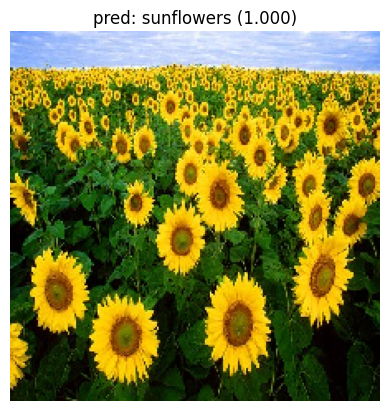

sunflowers  : 1.0000
dandelion   : 0.0000
daisy       : 0.0000
tulips      : 0.0000
roses       : 0.0000


{'해바라기2.jpg': [('sunflowers', 1.0),
  ('dandelion', 4.070047909809915e-10),
  ('daisy', 1.2622947825891018e-11),
  ('tulips', 6.712204170299454e-14),
  ('roses', 2.1951107855781686e-14)]}

In [131]:
# === Colab: 이미지 업로드 → 5클래스 예측 ===
from google.colab import files
uploaded = files.upload()  # 파일 선택 (여러 장 가능)

import numpy as np
import tensorflow as tf
from keras.utils import load_img, img_to_array
import matplotlib.pyplot as plt

# 모델 입력 크기 자동으로 가져오기 (예: (None, 224, 224, 3))
H, W = model.input_shape[1], model.input_shape[2]

# 클래스 이름 (train_ds.class_names가 있으면 그걸 쓰고, 없으면 아래 고정 리스트 사용)
try:
    class_names = list(train_ds.class_names)
except:
    class_names = ['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']

def prepare_image(img_path, target_size=(H, W)):
    """이미지를 모델 입력 크기로 리사이즈하고 (1,H,W,3) 배치로 반환.
       모델 내부에 전처리 레이어가 있다고 가정하므로 여기선 추가 스케일링 없음."""
    img = load_img(img_path, target_size=target_size, color_mode="rgb")
    x = img_to_array(img)              # 0~255 float32
    x = np.expand_dims(x, axis=0)      # (1,H,W,C)
    return img, x

def predict_image(img_path, topk=5):
    pil_img, x = prepare_image(img_path)

    # ⚠️ 만약 모델 내부에 [-1,1] 전처리가 없다면 아래 한 줄을 잠깐 켜세요.
    # x = (x / 127.5) - 1.0  # MobileNetV2 전처리

    probs = model.predict(x, verbose=0)[0]  # (num_classes,)
    topk_idx = np.argsort(probs)[::-1][:topk]
    topk_pairs = [(class_names[i], float(probs[i])) for i in topk_idx]

    # 시각화: Top-1 라벨/확률 제목으로 표시
    plt.imshow(pil_img); plt.axis("off")
    plt.title(f"pred: {topk_pairs[0][0]} ({topk_pairs[0][1]:.3f})")
    plt.show()

    # 상위 K개 확률 출력
    for name, p in topk_pairs:
        print(f"{name:12s}: {p:.4f}")
    return topk_pairs

# 업로드한 모든 파일에 대해 예측
results = {}
for fname in uploaded.keys():
    print(f"\n▶ {fname}")
    results[fname] = predict_image(fname, topk=len(class_names))

results  # 필요하면 결과 딕셔너리 확인


## Fine tuning




### Un-freeze a few top layers from the model

### Compiling the model for fine-tuning

### Fine tuning

### Evaluating the fine tuned model

### 이미지파일 테스트 해본다.